In [57]:
import pandas as pd
import sklearn
import quandl
import math, datetime
import numpy as np
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from matplotlib import style
import pickle
style.use('ggplot')

In [58]:
!nvidia-smi

Sun Mar 10 00:39:28 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 457.30       Driver Version: 457.30       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce MX250      WDDM  | 00000000:06:00.0 Off |                  N/A |
| N/A   38C    P0    N/A /  N/A |     64MiB /  2048MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [59]:
df = quandl.get('WIKI/GOOGL')
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


In [60]:
df = df[['Adj. Open','Adj. Close','Adj. High','Adj. Low','Adj. Volume']]
df['HL_PCT']=((df['Adj. High']-df['Adj. Close'])/df['Adj. Close']) * 100
df['PCT_Change']=(df['Adj. Close']-df['Adj. Open'])/df['Adj. Open']

In [61]:
df = df[['Adj. Close','HL_PCT','PCT_Change','Adj. Volume']]

In [62]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.01*len(df)))

In [63]:
df['label']=df[forecast_col].shift(-forecast_out)

df.tail()

,Adj. Close,HL_PCT,PCT_Change,Adj. Volume,label
Date,,,,,
2018-03-21,1094.00,1.343693,0.001309,1990515.0,NaN
2018-03-22,1053.15,2.921711,-0.024870,3418154.0,NaN
2018-03-23,1026.55,3.918952,-0.023607,2413517.0,NaN
2018-03-26,1054.09,0.491419,0.003322,3272409.0,NaN
2018-03-27,1006.94,5.720301,-0.053539,2940957.0,NaN


In [64]:
X = np.array(df.drop(['label'],axis=1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
df.dropna(inplace=True)


y = np.array(df['label'])



#X = X[:,-forecast_out+1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [65]:
clf = LinearRegression(n_jobs=-1)
#clf = svm.SVR(kernel='sigmoid')
clf.fit(X_train,y_train)
with open ('linearregression.pickle','wb') as f:
    pickle.dump(clf,f)

pickle_in = open('linearregression.pickle','rb')
clf = pickle.load(pickle_in)
forecast_set = clf.predict(X_lately)
accuracy = clf.score(X_test,y_test)


print(forecast_set, accuracy, forecast_out)

[1104.46555912 1074.84999647 1021.48135228 1063.18082814 1075.41538328
 1075.70335472 1094.36113775 1113.69837148 1116.85148103 1124.89789818
 1134.14515105 1131.71007577 1151.25639845 1166.9339258  1138.41204844
 1124.60160385 1090.23342079 1105.50703592 1116.56134538 1123.66088971
 1137.48340844 1152.2423484  1183.80761639 1188.26308103 1160.01752989
 1171.11541802 1172.96070766 1155.67963076 1120.95862063 1117.39130216
 1115.12758544 1072.18936071 1044.32979474 1075.27595092 1023.06931814] 0.9793864220258133 35


In [87]:
mse_lr = mean_squared_error(y_test, clf.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_lr))

The mean squared error (MSE) on test set: 1502.3090


In [66]:
print(accuracy)

0.9793864220258133


In [67]:
df['Forecast']=np.NaN
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix+=one_day
    df.loc[next_date]=[np.NaN for _ in range(len(df.columns)-1)]+[i]

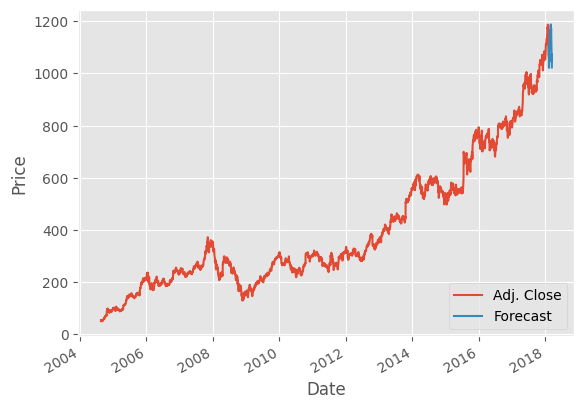

In [68]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc =4)
plt.xlabel('Date')
plt.ylabel("Price")
plt.show()

In [69]:
#Gradient Boosting based regressor
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=13
)

In [71]:
params = {
    "n_estimators": 400,
    "max_depth": 4,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}

In [72]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 1121.9357


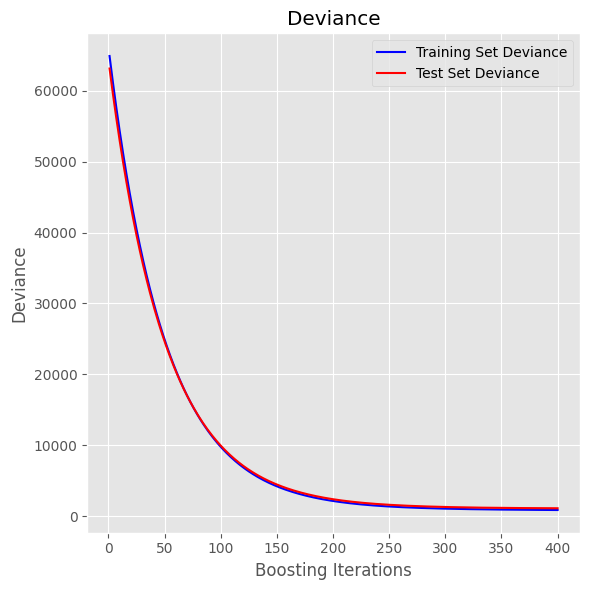

In [73]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()


In [74]:
feature_importance = reg.feature_importances_
print(feature_importance*100)

[9.97105723e+01 4.49113007e-02 2.89102175e-02 2.15606155e-01]


In [75]:
forecast_set_gb = reg.predict(X_lately)
accuracy_gb = reg.score(X_test,y_test)
print(accuracy_gb)

0.982524240766688


In [78]:
#Decision Tree Regression  
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train, y_train)

mse_dt = mean_squared_error(y_test, regressor.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse_dt))
                   

The mean squared error (MSE) on test set: 1928.3002


In [79]:
forecast_set_dt = regressor.predict(X_lately)
accuracy_dt = regressor.score(X_test,y_test)
print(accuracy_dt)

0.9699639547926842


In [85]:
data_model = [['Decision\nTree', accuracy_dt.round(5)], ['Linear\nRegression', accuracy.round(5)], ['Gradient\nBoosting', accuracy_gb.round(5)]]
 
# Create the pandas DataFrame
df_model = pd.DataFrame(data_model, columns=['Model Name', 'Accuracy'])
df_model.head()

,Model Name,Accuracy
0,Decision\nTree,0.96996
1,Linear\nRegression,0.97939
2,Gradient\nBoosting,0.98252


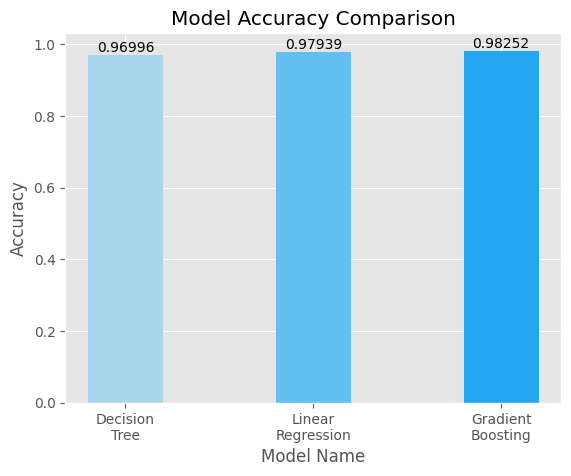

In [86]:
#df_model['Accuracy'].plot()
colors = ["#a7d5ed", "#63bff0", "#22a7f0", "#1984c5"]
plt.bar(df_model['Model Name'], df_model['Accuracy'], width=0.4, color=colors)

# Add labels and title
plt.xlabel("Model Name")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")

for i, value in enumerate(df_model['Accuracy']):
    plt.text(i, value, str(value), ha='center', va='bottom')